In [1]:
import sys
from pathlib import Path

WORKSPACE_PATH = Path.cwd().parent.parent
SRC_PATH = str(WORKSPACE_PATH / "src")

if SRC_PATH not in sys.path:
    sys.path.insert(0, SRC_PATH)
    print(f"echo $PATH={sys.path}")

echo $PATH=['/Users/jeanmetz/workspace/playground-llm-pytorch/src', '/Users/jeanmetz/.pyenv/versions/3.12.2/lib/python312.zip', '/Users/jeanmetz/.pyenv/versions/3.12.2/lib/python3.12', '/Users/jeanmetz/.pyenv/versions/3.12.2/lib/python3.12/lib-dynload', '', '/Users/jeanmetz/workspace/playground-llm-pytorch/.venv/lib/python3.12/site-packages']


In [2]:
import random
from micrograd.engine import Operand
from typing import Sequence
from micrograd.visualization import build_computation_graph

# A simple neuron class definition

In [3]:
class Neuron:
    def __init__(self, num_inputs: int) -> None:
        self.weights = [Operand(random.uniform(-1, 1)) for _ in range(num_inputs)]  # noqa: S311
        self.bias = Operand(random.uniform(-1, 1))  # noqa: S311

    def __call__(self, inputs: Sequence[Operand | int | float]) -> Sequence[Operand]:
        # calculate the (x*w + b) expression for this neuron
        value = sum((xi * wi for xi, wi in zip(inputs, self.weights)), start=self.bias)
        # return the result of the activation function
        return value.tanh()

    def parameters(self) -> list:
        return [*self.weights, self.bias]

In [4]:
n = Neuron(2)
x = [2.0, 3.0]

# forward the inputs x to a single Neuron object
neuron_output = n(x)
neuron_output

Operand(data=-0.9995184812970971)

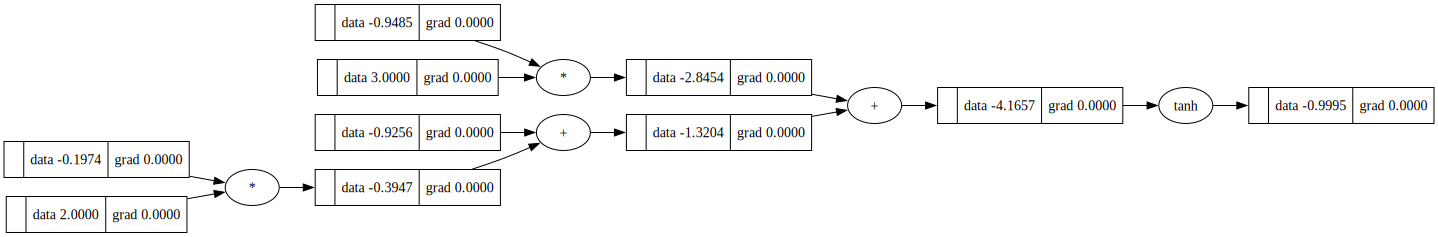

In [5]:
build_computation_graph(neuron_output)

# Defining a Layer class as a sequence of Neurons

In [6]:
class Layer:
    def __init__(self, num_inputs: int, num_outputs: int) -> None:
        self.neurons = [Neuron(num_inputs) for _ in range(num_outputs)]

    def __call__(self, inputs: Sequence[Operand | int | float]) -> Sequence[Operand]:
        output = [neuron(inputs) for neuron in self.neurons]
        return output[0] if len(output) == 1 else output

    def parameters(self) -> list:
        return [param for neuron in self.neurons for param in neuron.parameters()]

In [7]:
layer = Layer(2, 5)  # 2 inputs and 5 outputs
x = [2.0, 3.0]

# forward the inputs to a single layer object
layer_output = layer(x)
layer_output

[Operand(data=-0.9832944072559223),
 Operand(data=-0.33507223832090277),
 Operand(data=-0.9596637843086332),
 Operand(data=0.5475500881892026),
 Operand(data=0.9999015578933037)]

# Defining the Multilayer Perceptron network

a MLP is a sequence of Layers (hidden layers) of Neurons

In [8]:
class MLP:
    def __init__(self, num_inputs: int, layers_num_outputs: list[int]) -> None:
        shapes = [num_inputs, *layers_num_outputs]
        self.layers = [Layer(shapes[i], shapes[i + 1]) for i in range(len(shapes) - 1)]

    def __call__(self, inputs: Sequence[Operand | int | float]) -> Sequence[Operand]:
        x = inputs
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(
        self,
    ) -> list:
        return [param for layer in self.layers for param in layer.parameters()]

In [9]:
net = MLP(3, [4, 4, 1])  # 2 inputs and 5 outputs
x = [2.0, 3.0, -1.0]

# forward the inputs into the net
net(x)

Operand(data=0.8631281762438198)

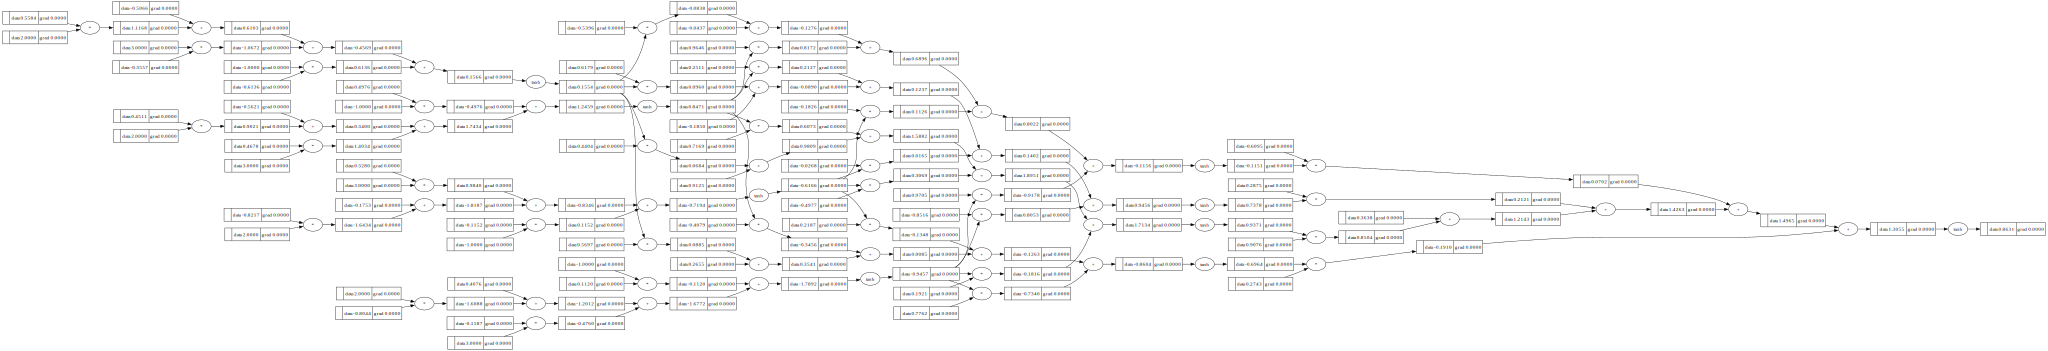

In [10]:
build_computation_graph(net(x))

# A simple binary classifier example with a tiny dataset

In [11]:
features = [
    [2.0, 3.0, -1.0],  # sample 1
    [3.0, -1.0, 0.5],  # sample 2
    [0.5, 1.0, 1.0],  # sample 3
    [1.0, 1.0, -1.0],  # sample 4
]

true_labels = [1.0, -1.0, -1.0, 1.0]  # targets

In [12]:
net = MLP(3, [4, 4, 1])  # 2 inputs and 5 outputs

In [13]:
params = net.parameters()
params

[Operand(data=-0.8335962976200249),
 Operand(data=0.9994128619222795),
 Operand(data=-0.7164457109508866),
 Operand(data=0.9834693084677841),
 Operand(data=0.974175865445478),
 Operand(data=-0.732120257162866),
 Operand(data=0.18633085878767042),
 Operand(data=0.13114739776230477),
 Operand(data=0.9827879594595506),
 Operand(data=0.03843181110869831),
 Operand(data=0.13842088240422457),
 Operand(data=0.4972260554424679),
 Operand(data=0.8171552578961179),
 Operand(data=0.18996613025943976),
 Operand(data=0.8218514139773583),
 Operand(data=-0.8419980669407094),
 Operand(data=-0.6061851276063328),
 Operand(data=0.9806395994711075),
 Operand(data=0.782708983332991),
 Operand(data=0.24752229049149577),
 Operand(data=0.5648236703978629),
 Operand(data=0.43964057477917273),
 Operand(data=0.6314324821784152),
 Operand(data=0.14451030788347374),
 Operand(data=-0.7514741424457387),
 Operand(data=0.12353193818285146),
 Operand(data=0.009178648870302064),
 Operand(data=-0.02115744998204816),
 Ope

In [14]:
len(params)

41

In [15]:
# forward the examples into the net
predictions = [net(x) for x in features]
predictions

[Operand(data=0.7749696250317536),
 Operand(data=0.851429603198206),
 Operand(data=0.8260264347990187),
 Operand(data=0.802357285576584)]

In [16]:
# MSE (mean squared error loss)
loss = sum((pred - truth) ** 2 for truth, pred in zip(true_labels, predictions))
loss

Operand(data=6.851865428406486)

In [17]:
# Calculating the gradients (using the micrograd engine)
loss.backward()

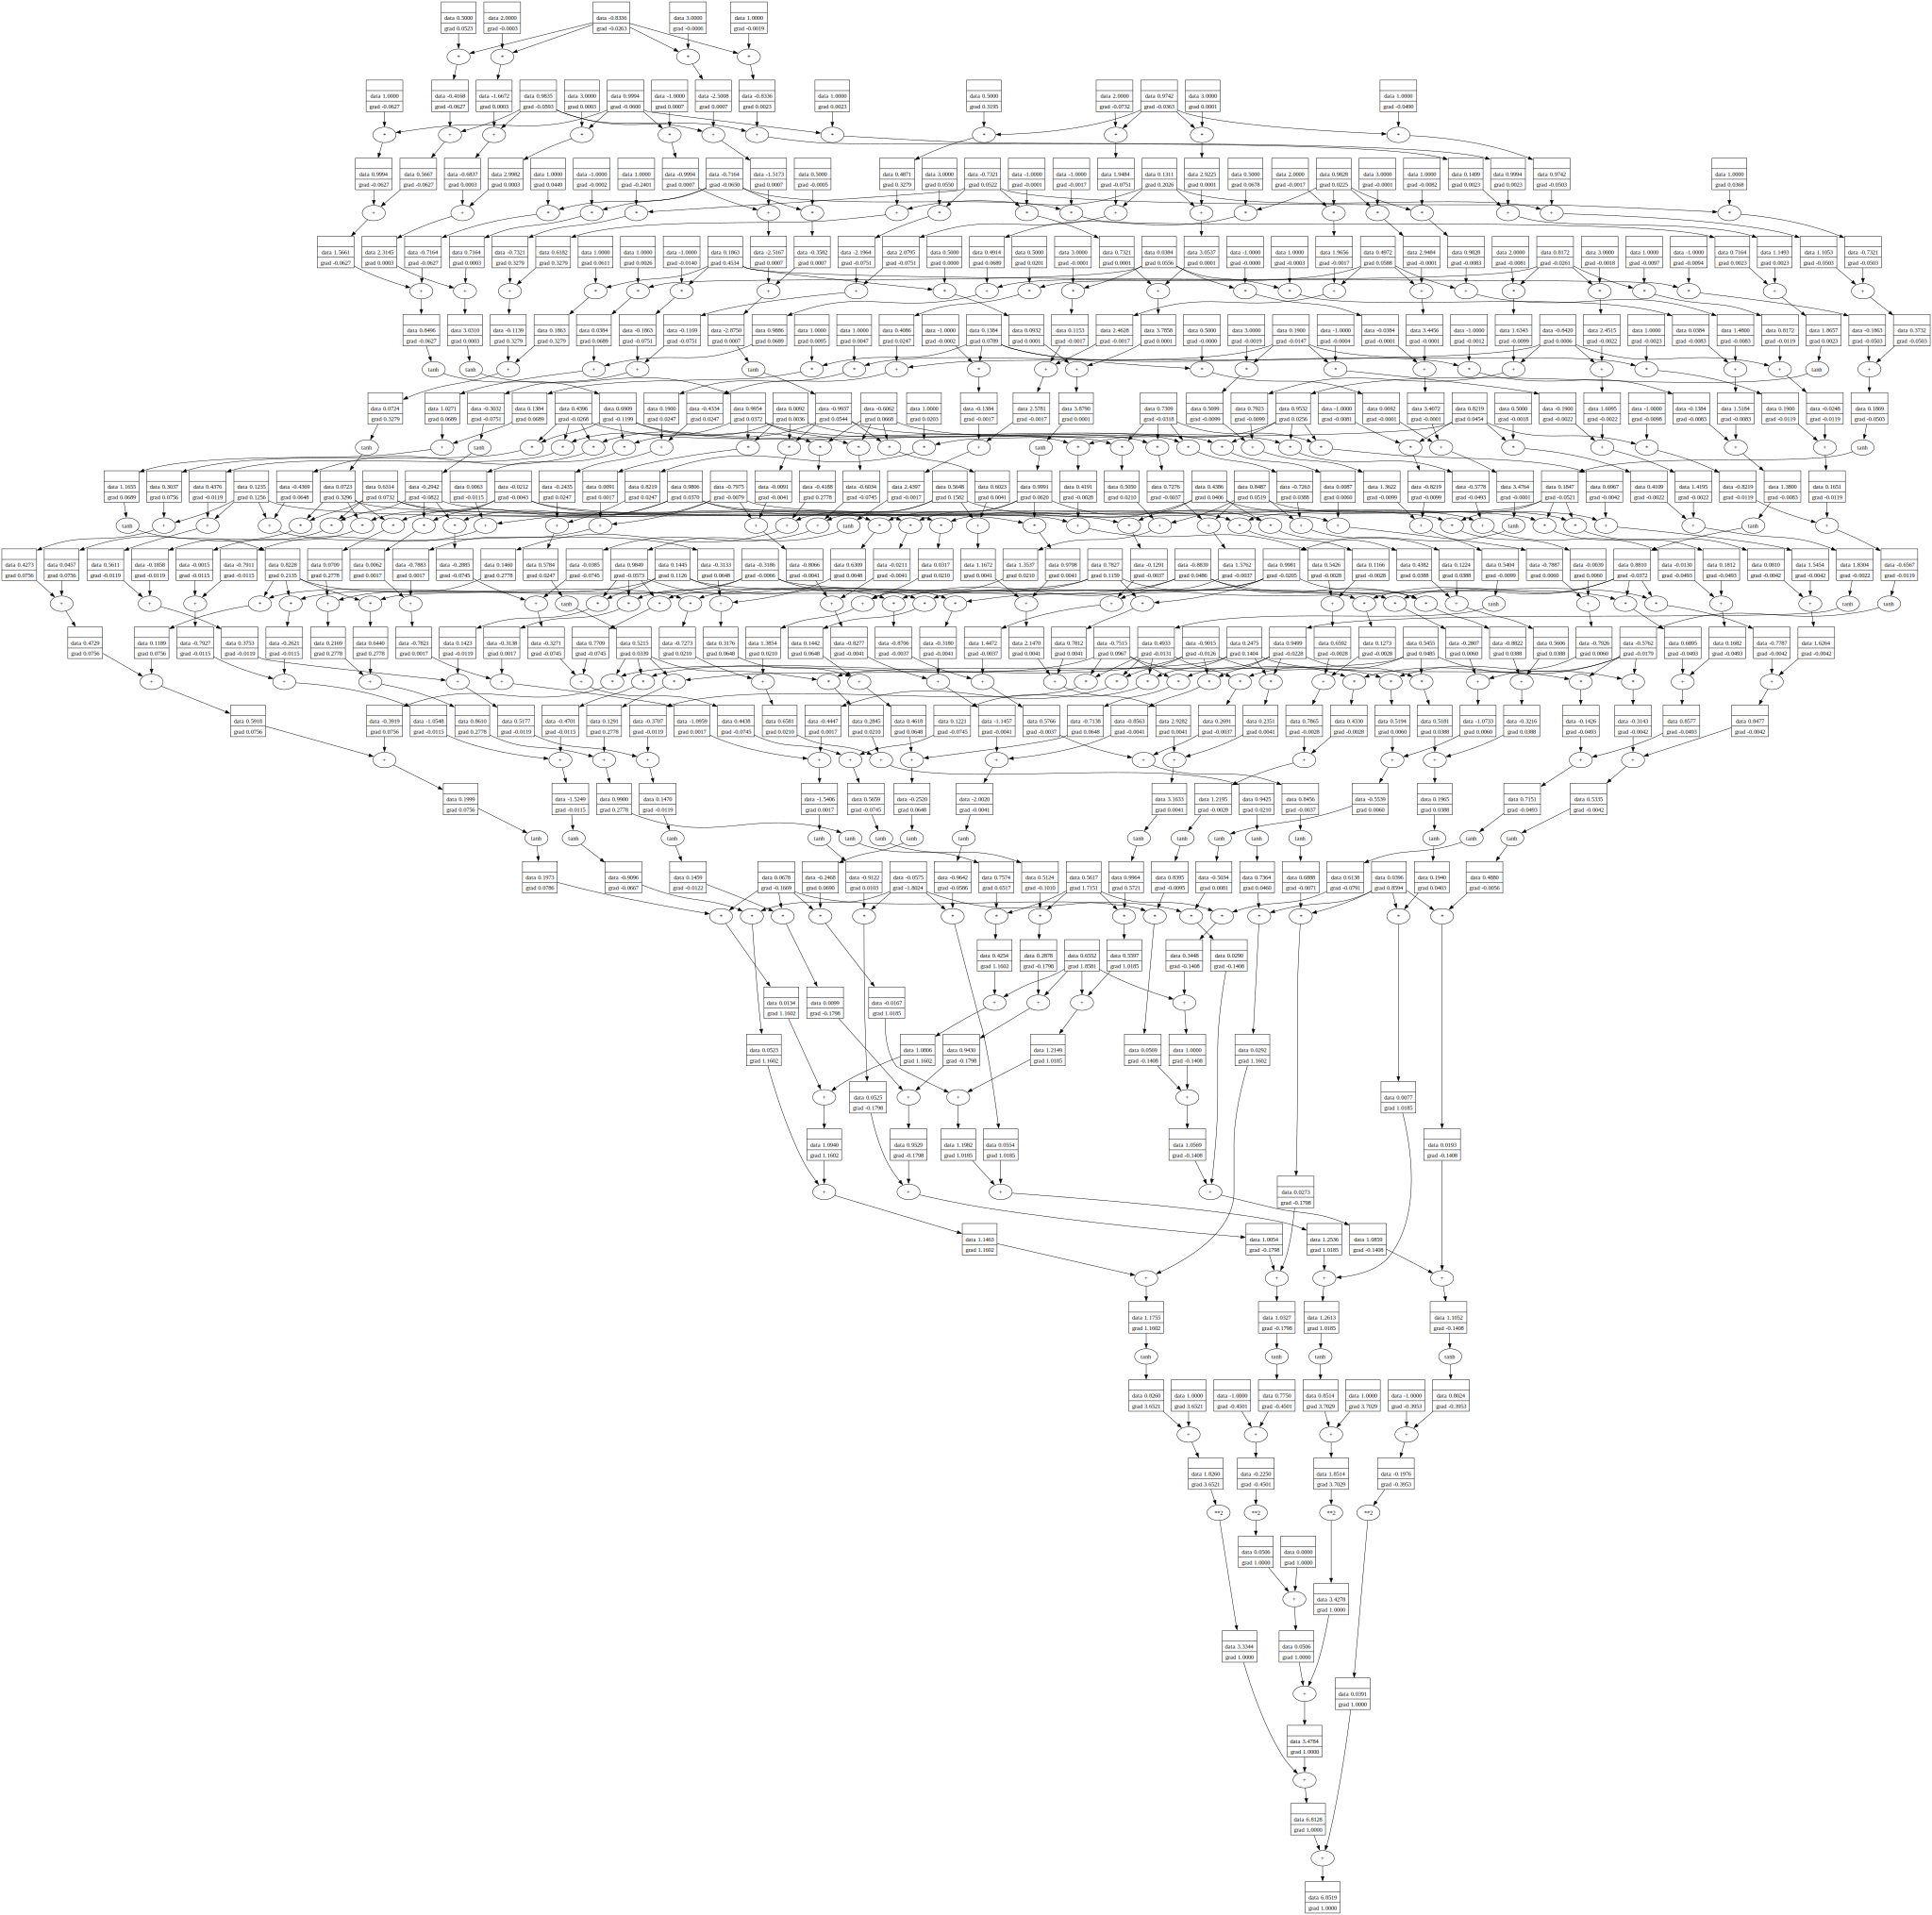

In [18]:
build_computation_graph(loss, rankdir="top-to-bottom")

In [19]:
print(net.layers[0].neurons[0].weights[0])
print(net.layers[0].neurons[0].weights[0].grad)

Operand(data=-0.8335962976200249)
-0.026253241463388866


In [20]:
step_size = 0.01
# nudging the parameters to minimize the loss
for p in net.parameters():
    p.data += -step_size * p.grad

In [21]:
print(net.layers[0].neurons[0].weights[0])
print(net.layers[0].neurons[0].weights[0].grad)

Operand(data=-0.8333337652053909)
-0.026253241463388866


In [22]:
# forward pass + loss calculation
predictions = [net(x) for x in features]
loss = sum((pred - truth) ** 2 for truth, pred in zip(true_labels, predictions))
loss  # expected slightly lower than previous

Operand(data=6.739780134461849)

# Putting Gradient Descent together ...

... in a training loop

In [23]:
features = [
    [2.0, 3.0, -1.0],  # sample 1
    [3.0, -1.0, 0.5],  # sample 2
    [0.5, 1.0, 1.0],  # sample 3
    [1.0, 1.0, -1.0],  # sample 4
]

true_labels = [1.0, -1.0, -1.0, 1.0]  # targets

In [27]:
step_size = 0.01
steps = 100
net = MLP(3, [4, 4, 1])  # redefine the NN

In [28]:
# Optimization:
for step in range(steps):
    # forward pass
    predictions = [net(x) for x in features]
    loss = sum((pred - truth) ** 2 for truth, pred in zip(true_labels, predictions))

    # backward pass
    for p in net.parameters():  # zero the gradients first
        p.grad = 0.0
    loss.backward()

    # parameters updates
    for p in net.parameters():
        p.data += -step_size * p.grad

    print(f"[{step}] loss: {loss.data:.4f}")

[0] loss: 5.5310
[1] loss: 5.1175
[2] loss: 4.6538
[3] loss: 4.1665
[4] loss: 3.6929
[5] loss: 3.2659
[6] loss: 2.8983
[7] loss: 2.5840
[8] loss: 2.3095
[9] loss: 2.0632
[10] loss: 1.8382
[11] loss: 1.6322
[12] loss: 1.4451
[13] loss: 1.2778
[14] loss: 1.1306
[15] loss: 1.0030
[16] loss: 0.8934
[17] loss: 0.7998
[18] loss: 0.7199
[19] loss: 0.6515
[20] loss: 0.5928
[21] loss: 0.5420
[22] loss: 0.4980
[23] loss: 0.4595
[24] loss: 0.4258
[25] loss: 0.3959
[26] loss: 0.3695
[27] loss: 0.3459
[28] loss: 0.3248
[29] loss: 0.3057
[30] loss: 0.2886
[31] loss: 0.2730
[32] loss: 0.2588
[33] loss: 0.2458
[34] loss: 0.2339
[35] loss: 0.2230
[36] loss: 0.2130
[37] loss: 0.2037
[38] loss: 0.1951
[39] loss: 0.1871
[40] loss: 0.1797
[41] loss: 0.1728
[42] loss: 0.1663
[43] loss: 0.1603
[44] loss: 0.1546
[45] loss: 0.1493
[46] loss: 0.1443
[47] loss: 0.1395
[48] loss: 0.1351
[49] loss: 0.1309
[50] loss: 0.1269
[51] loss: 0.1231
[52] loss: 0.1196
[53] loss: 0.1162
[54] loss: 0.1129
[55] loss: 0.1099
[5

In [29]:
predictions

[Operand(data=0.9155188114079787),
 Operand(data=-0.9282899661102916),
 Operand(data=-0.8715257423515677),
 Operand(data=0.8633097035754972)]